## CS484 Final Project: Image inpainting using Object removal

Hello all
This is the showcase of our project

#### Section 1: Data gathering and cleaning
downloading the data and storing it on local file made easy. might create a seprate python file to streamline the process on the notebook ?

In [13]:
! pip install "deeplake<4.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.9 MB/s eta 0:0

In [3]:
import torch
from torch.utils.data import DataLoader
import torchvision.io as tvio
import torchvision.transforms as tfs
import torchvision.transforms.functional as tF

from download_dataset import DatasetDownloader
import numpy as np
import matplotlib.pyplot as plt

from utility_functions import RectanglePatch, CrossPatch, RandomHFlip, RandomVFlip, PairColorJitter, RandomResizeCrop, PairToTensors, PairNormalize, MakePair
from torch.utils.data import Dataset

from utility_functions import thinXMask, thickXMask, showResults
from basic_methods import nearestNeighbors, gaussianInpaint


In [3]:
#ds = DatasetDownloader.get_places()
#ds.visualize()

#### Section 2: Simple mathematical inpainting

Two simple ways to do inpainting is using gaussian blur, and nearest neighbors

Similar to clone stamp on photoshop


#### Set up images and masks

In [5]:
abbey = np.mean(np.load('images/abbey0.jpg.npy'), axis=2)

thinMask = thinXMask(abbey)
thickMask = thickXMask(abbey)

abbeyDamaged = abbey.copy()
abbeyDamaged[thinMask == 1] = 255

abbeyDamaged2 = abbey.copy()
abbeyDamaged2[thickMask == 1] = 255


#### Nearest Neighbors

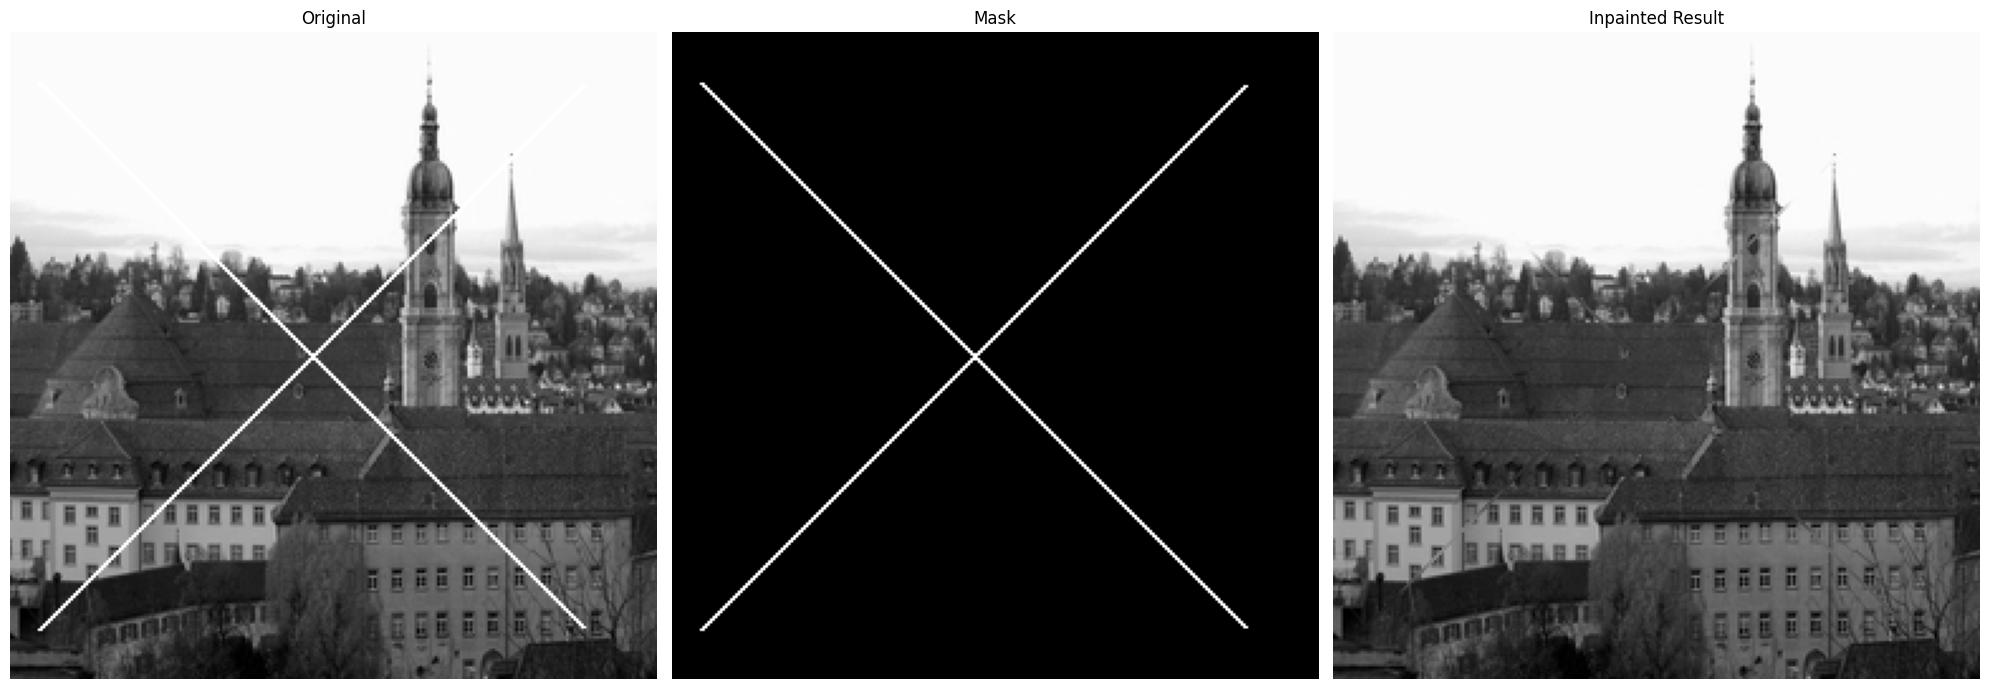

In [6]:

inpainted_image = nearestNeighbors(abbeyDamaged, thinMask)
showResults(abbeyDamaged, thinMask, inpainted_image)

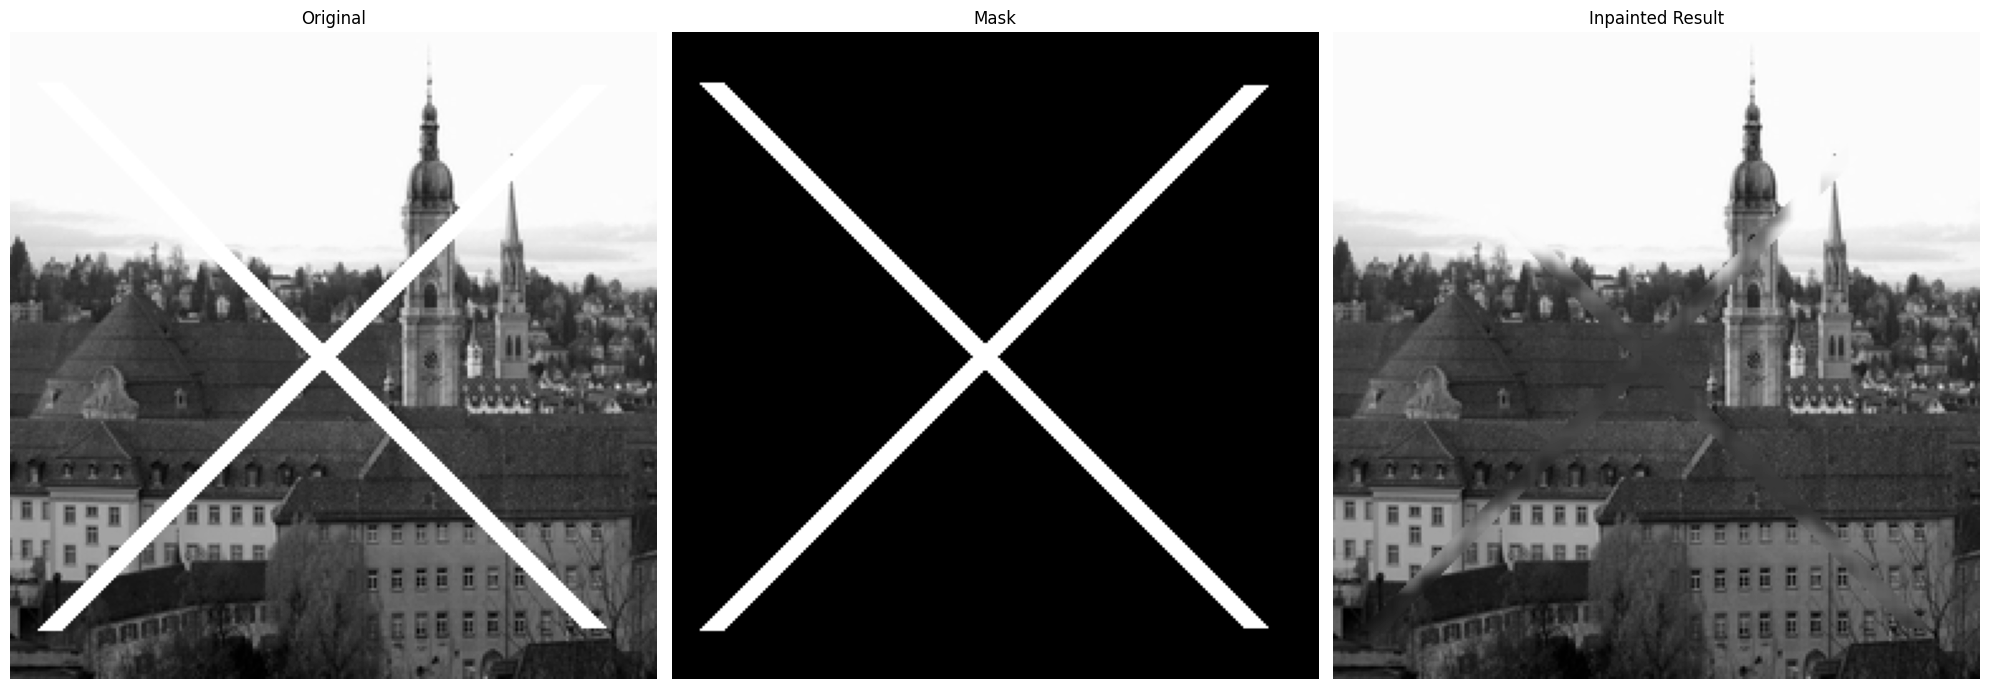

In [7]:
inpainted_image = nearestNeighbors(abbeyDamaged2, thickMask)
showResults(abbeyDamaged2, thickMask, inpainted_image)

#### Gaussian Blur

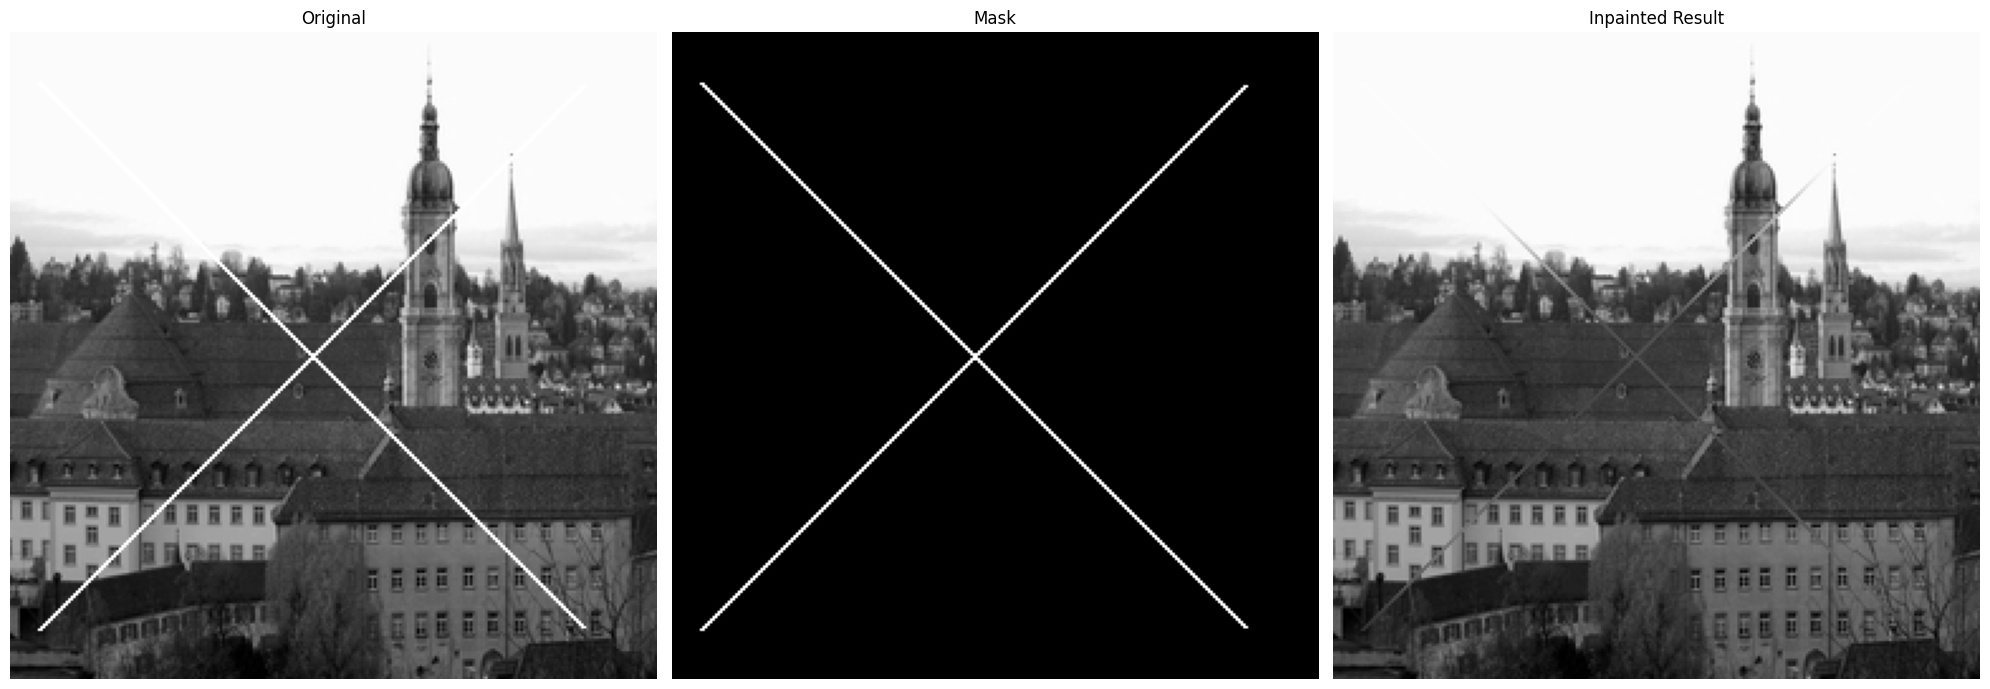

In [8]:
res = gaussianInpaint(abbeyDamaged, thinMask)
showResults(abbeyDamaged, thinMask, res)


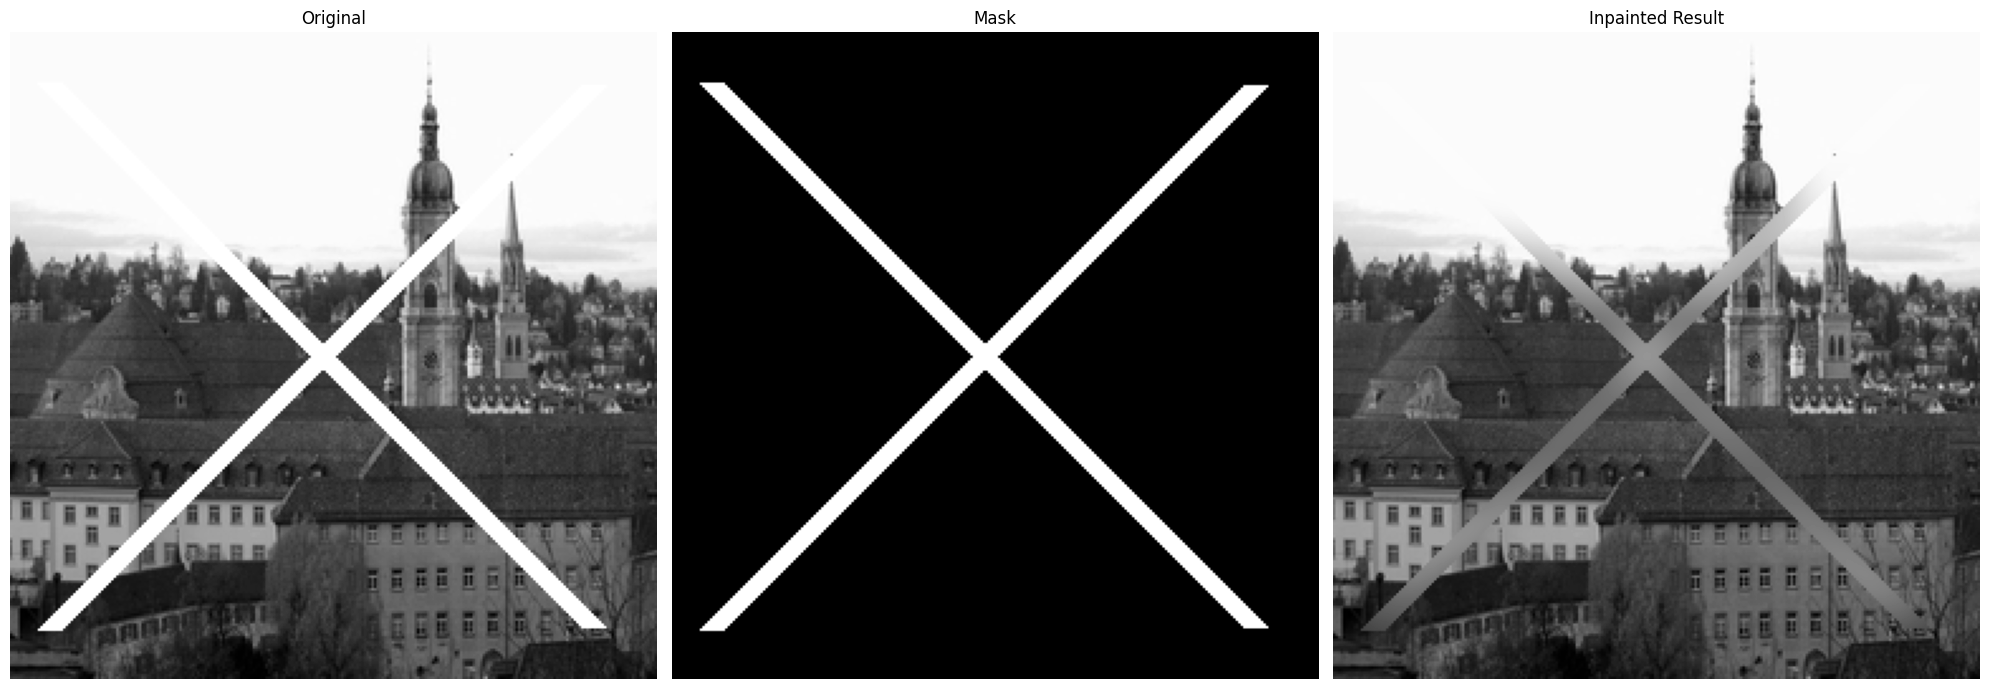

In [9]:
res = gaussianInpaint(abbeyDamaged2, thickMask)
showResults(abbeyDamaged2, thickMask, res)

#### Section 3: Object detection and removal
for this section we will be using either two methods for patch selection:
- simple rectangle patch
- Object selection using deep segmentaiton methods with the help  of labels like in A5 ? (optional)

The goal of this section is to create the dataset that is ready to be used for training/validating. for each image in the data set we should have an (Image - patch, Image) in the final dataset, ready to be trained (or in the least, the region to be removed is somehow indicated?)

In [5]:

training_img_transform = tfs.Compose([
  MakePair(),
  RandomHFlip(),
  RandomVFlip(),
  PairColorJitter(),
  RandomResizeCrop(size=256, min_scale=0.7, max_scale=1.3),
  RectanglePatch(patch_size=(100,100)),
  # PairToTensors()
  # PairNormalize(mean = ???, std = ???)
  ])

validation_img_transform = tfs.Compose([
    MakePair(),
    PairToTensors(),
   # PairNormalize( mean = ???, std = ???)
])

training_cross_transform = tfs.Compose([
  MakePair(),
  RandomHFlip(),
  RandomVFlip(),
  PairColorJitter(),
  RandomResizeCrop(size=256, min_scale=0.7, max_scale=1.3),
  CrossPatch(patch_size=5),
  # PairToTensors()
])

In [16]:
ds = DatasetDownloader.get_places()
training_data, validation_data = torch.utils.data.random_split(ds, [0.8, 0.2])

class CustomPlaces(Dataset):
    def __init__(self, data, transform=None):
        self.ds = data.dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img = self.ds.images[idx].numpy().copy()
        withPatch, target = self.transform(img)
        return withPatch, target

training_ds = CustomPlaces(data = training_data, transform=training_img_transform)
validating_ds = CustomPlaces(data = validation_data, transform=validation_img_transform)

training_cross_ds = CustomPlaces(data = training_data, transform=training_cross_transform)
validating_cross_ds = CustomPlaces(data = validation_data, transform=validation_img_transform)


-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/places205



-

hub://activeloop/places205 loaded successfully.



Dataset(path='hub://activeloop/places205', read_only=True, tensors=['images', 'labels'])


DS Dataset(path='hub://activeloop/places205', read_only=True, tensors=['images', 'labels'])


(-0.5, 255.5, 255.5, -0.5)

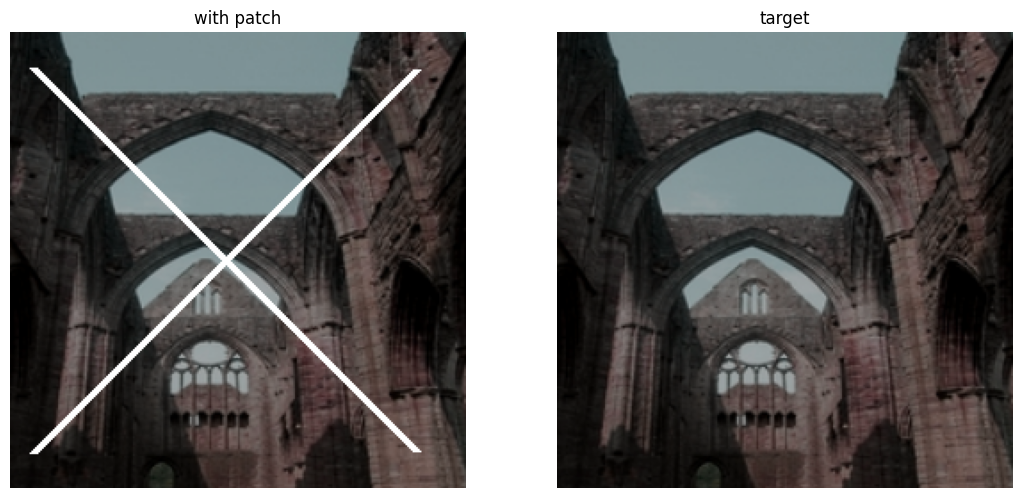

In [17]:
#feel free to delete
x = training_cross_ds[3]

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.imshow(x[0], vmin=0, vmax=255)
plt.title('with patch')
plt.axis('off')

plt.subplot(132)
plt.imshow(x[1], vmin=0, vmax=255)
plt.title('target')
plt.axis('off')

In [ ]:
# these are just copied from A5
TRAIN_BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(training_ds, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(validating_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

In [ ]:
train_cross_loader = DataLoader(training_ds, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val__cross_loader = DataLoader(validating_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

#### Section 4: Creating the  model for the network
the first simple approach would be to use an autoencoder and self-supervision to fit the model to the dataset.

questions:
- how good would the image quality be?
- what if we change the location of the patch?
- how would loss functions affect the quality of the output?
- what if patch was not rectangular?
- how to avoid overfitting?

#### Section 3.1: Training the model, displaying the results

#### Section 5: GANS, creating competition for the network using a "detector"

#### Section 5.1: Training the model, displaying the results

#### Section 6(if we had time): using image segmentation from assignment 4 part 2, to remove objects from image and using network from before to fill in the "patch"